# Simulation and Inference of Interferometry on Growing Thin Films

We are interested in sumulating the reflectance of growing thin films (forward modeling) and infer the growth behavior from measurements.

## Imports

In [163]:
# numerics
import jax.numpy as jnp
import jax
import optax

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# our library
from reflax import polanalyze, variable_layer_thickness_simulation

## Simulation

### General Setup

Let us first specify parameters of the experimental setup

In [164]:
wavelength = 632.8
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)
polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

We also generally assume

In [165]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

backside_mode = 1

and consider a setup with two static-thickness layers with parameters

In [166]:
static_layer_thicknesses = jnp.array([24.2, 10.0])
permeability_static_size_layers = jnp.array([1.0, 1.0])
permittivity_static_size_layers = jnp.array([1.57**2, 1.45704**2])

Let there further be a layer of variable thickness, with properties

In [167]:
permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

### Growth model for the variable layer

We simulate over the timespan

In [168]:
final_time = 7049
time_points = jnp.arange(0, final_time)

Given a linear growth rate

In [169]:
layer_growing_rate = 747.9 / (7049 / 60) / 60

this yields the following thicknesses of the variable layer

In [170]:
variable_layer_thicknesses = time_points * layer_growing_rate

### Running the simulation

In [171]:
reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    variable_layer_thicknesses = variable_layer_thicknesses
)

### Profiling the simulation

In [172]:
%%timeit
reflection_coefficients, transmission_coefficients, conservation_checks = jax.block_until_ready(variable_layer_thickness_simulation(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    variable_layer_thicknesses = variable_layer_thicknesses
))

10.4 ms ± 720 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Interactive Plotting

In [173]:
from ipywidgets import interact
import ipywidgets as widgets
@interact(polar_angle_deg = 25, vfac = 1.0, a_fac = 0.0)
def int_plot(polar_angle_deg, vfac, a_fac):
    reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
        wavelength = wavelength,
        polar_angle = jnp.deg2rad(polar_angle_deg),
        azimuthal_angle = azimuthal_angle,
        transverse_electric_component = transverse_electric_component,
        transverse_magnetic_component = transverse_magnetic_component,
        permeability_reflection = permeability_reflection,
        permittivity_reflection = permittivity_reflection,
        permeability_transmission = permeability_transmission,
        permittivity_transmission = permittivity_transmission,
        backside_mode = backside_mode,
        permeability_static_size_layers = permeability_static_size_layers,
        permittivity_static_size_layers = permittivity_static_size_layers,
        static_layer_thicknesses = static_layer_thicknesses,
        permeability_variable_layer = permeability_variable_layer,
        permittivity_variable_layer = permittivity_variable_layer,
        variable_layer_thicknesses = variable_layer_thicknesses * vfac + variable_layer_thicknesses ** 2 * a_fac
    )
    plt.plot(time_points, conservation_checks * 100, '-g', linewidth=1, label="Conservation")
    plt.plot(time_points, reflection_coefficients * 100, '-b', linewidth=1, label="Reflectance")
    plt.plot(time_points, transmission_coefficients * 100, '-r', linewidth=1, label="Transmittance")
    plt.xlim([0, final_time])
    plt.ylim([0, 110])
    plt.xlabel("Time in s")
    plt.ylabel("Power fractions in %")
    plt.legend(loc="upper right")

interactive(children=(IntSlider(value=25, description='polar_angle_deg', max=75, min=-25), FloatSlider(value=1…

## Data Analysis

Text(0.5, 1.0, 'measurement')

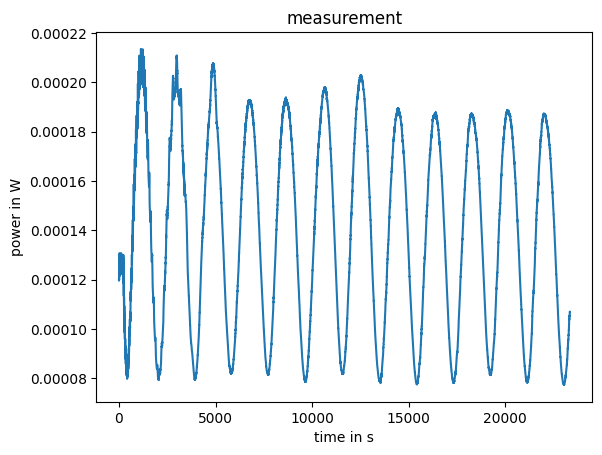

In [174]:
# Define the CSV file path
file_path = 'data/measurement2.csv'

# Read the CSV, skipping rows until the data table starts
df = pd.read_csv(file_path, sep=';', skiprows=14, decimal=',')
df.columns = df.columns.str.strip()

# Strip whitespace and convert to datetime objects
df['Time'] = pd.to_datetime(df['Time of day (hh:mm:ss)'].str.strip(), format='%H:%M:%S.%f')

# Calculate time since the start
start_time = df['Time'].iloc[0]
df['Time Since Start (seconds)'] = (df['Time'] - start_time).dt.total_seconds()

# Save as jnp arrays
time_points_measured = jnp.asarray(df['Time Since Start (seconds)'])
power_measured = jnp.asarray(df["Power (W)"])

# Display the result
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("measurement")


There seem to be artefacts in the measurement at the beginning up until ~1800 seconds (see the non-smooth transition there). We will cut this part of the measurement away.

In [175]:
time_points_measured = time_points_measured[1850:]
power_measured = power_measured[1850:]

Which looks much better

Text(0.5, 1.0, 'cleaned measurement')

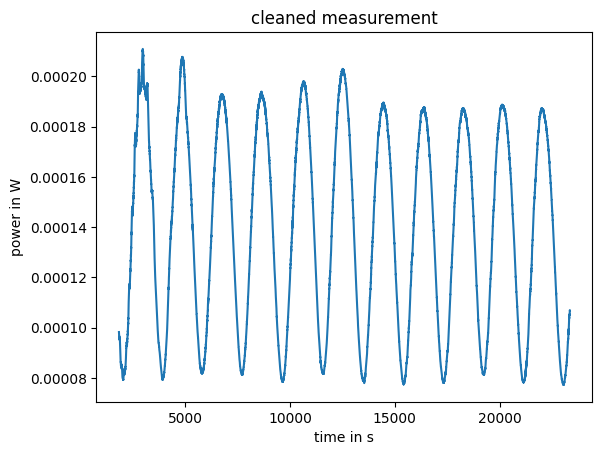

In [176]:
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")

### Wavelet analysis

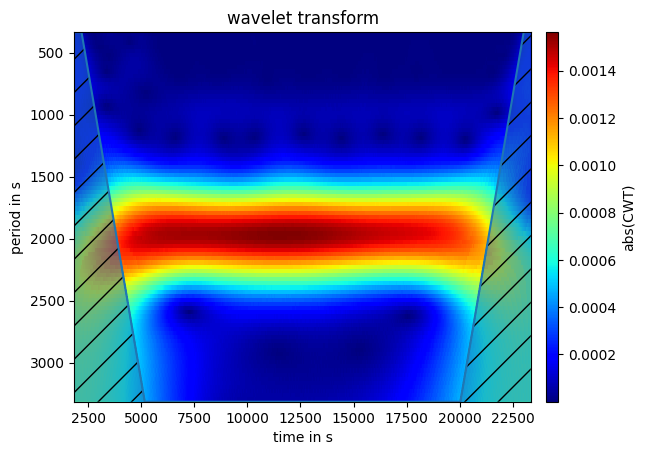

In [177]:
from reflax.scaleogram import cws
import numpy as np

def plot_scaleogram(ax, time_points, signal, title, ylabel = "period in s", xlabel = "time in s", cbarlabel = "abs(CWT)", yscale = "linear", cscale = "linear", scales = np.arange(10, 1000, 10), clim = None, coi=True): # scales = np.arange(100, 2200, 20)
    cws(time = time_points, signal = signal, ax = ax, scales = scales, wavelet="cmor1-1.5", coikw={'alpha':0.5,'hatch':'/'}, ylabel = ylabel, xlabel = xlabel, title = title, cscale = cscale, yscale = yscale, cbarlabel = cbarlabel, clim = clim, coi=coi)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_measured, "wavelet transform", scales = np.arange(500, 5000, 50), coi=True)


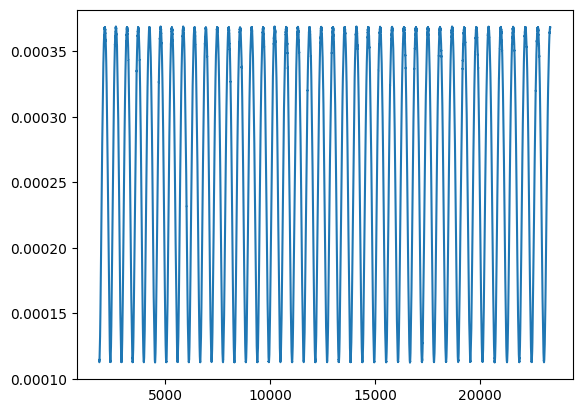

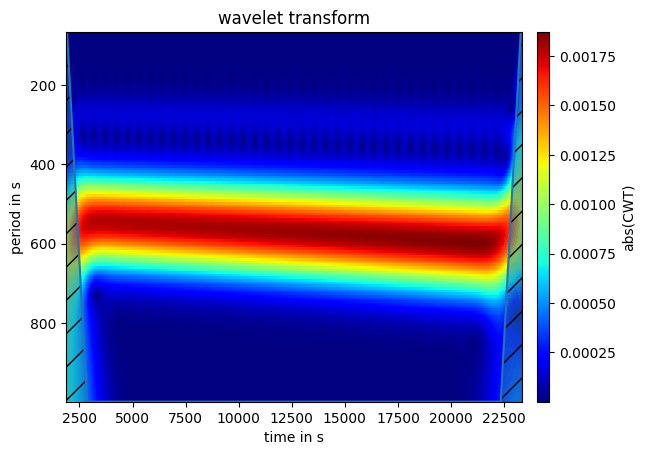

In [178]:
initial_layer_thickness = 170
layer_growing_rate = 0.4
layer_growing_acceleration = -1e-6
power_conversion_factor = 0.00075
power_conversion_constant = 0.00008

from reflax.forward_model import power_forward_model

power_simulated = power_forward_model(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    timepoints_measured = time_points_measured,
    initial_thickness = initial_layer_thickness,
    growth_velocity = layer_growing_rate,
    growth_acceleration = layer_growing_acceleration,
    power_conversion_factor = power_conversion_factor,
    power_consversion_constant = power_conversion_constant
)

plt.plot(time_points_measured, power_simulated)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_simulated, "wavelet transform", scales = np.arange(100, 1500, 10), coi=True)

## Inference

### Inference by hand

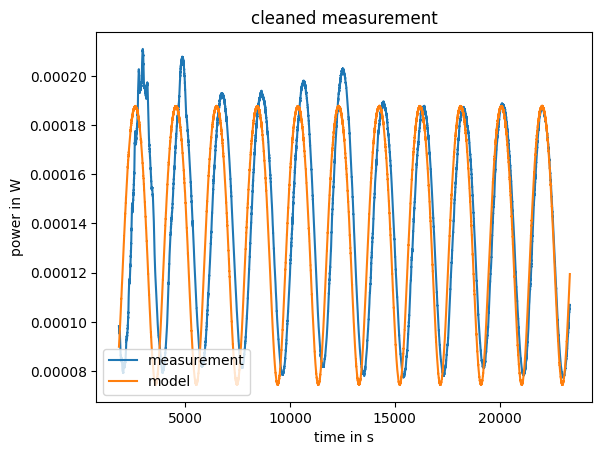

In [184]:
# initial_layer_thickness = 170
# layer_growing_rate = 747.9 / (7049 / 60) / 60
# layer_growing_acceleration = -0.0000004

# 1.7000000e+02  1.0696702e-01 -5.1498353e-07
# 1.07924394e-01 -6.79976267e-07

# initial_layer_thickness = 170
initial_layer_thickness = 100
layer_growing_rate = 1.07924394e-01
# layer_growing_acceleration = -6.79976267e-07
layer_growing_acceleration = 0



# simple accelerated model
layer_thickness_model = initial_layer_thickness + layer_growing_rate * time_points_measured + layer_growing_acceleration * time_points_measured ** 2

reflection_coefficients, _, _ = variable_layer_thickness_simulation(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    variable_layer_thicknesses = layer_thickness_model
)

# power_conversion_factor = 0.00075
# power_conversion_constant = 0.00008

power_conversion_factor = 3.32e-4
power_conversion_constant = 0.00006

power_model = power_conversion_factor * reflection_coefficients + power_conversion_constant

plt.plot(time_points_measured, power_measured, label = "measurement")
plt.plot(time_points_measured, power_model, label = "model")
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")
plt.legend(loc = "lower left")

### Computational optimization

Step: 0, Accepted steps: 0, Steps since acceptance: 0, Loss on this step: 8.970002454589121e-06, Loss on the last accepted step: 0.0, Step size: 1.0
Step: 1, Accepted steps: 1, Steps since acceptance: 0, Loss on this step: 4.7762318899913225e-06, Loss on the last accepted step: 8.970002454589121e-06, Step size: 3.5
Step: 2, Accepted steps: 2, Steps since acceptance: 0, Loss on this step: 2.3664756554353517e-06, Loss on the last accepted step: 4.7762318899913225e-06, Step size: 12.25
Step: 3, Accepted steps: 3, Steps since acceptance: 0, Loss on this step: 1.7571196622157004e-06, Loss on the last accepted step: 2.3664756554353517e-06, Step size: 42.875
Step: 4, Accepted steps: 4, Steps since acceptance: 0, Loss on this step: 1.7274895753871533e-06, Loss on the last accepted step: 1.7571196622157004e-06, Step size: 150.0625
Step: 5, Accepted steps: 5, Steps since acceptance: 0, Loss on this step: 1.726993900774687e-06, Loss on the last accepted step: 1.7274895753871533e-06, Step size: 52

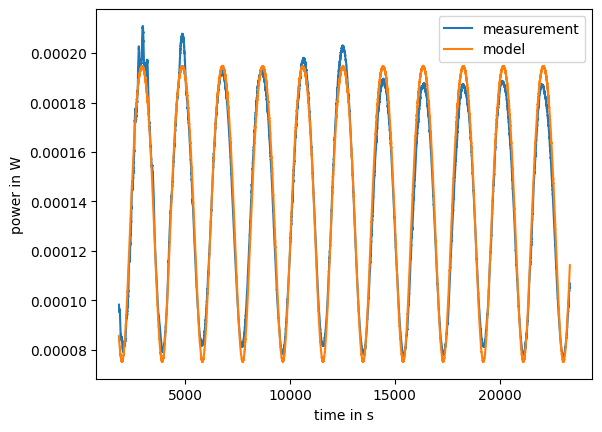

In [182]:
from reflax import power_forward_residuals

def residuals(params, consts):
    initial_thickness, growth_velocity, growth_acceleration = params
    return power_forward_residuals(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    timepoints_measured = time_points_measured,
    power_measured = power_measured,
    initial_thickness = initial_thickness,
    growth_velocity = growth_velocity,
    growth_acceleration = growth_acceleration,
    power_conversion_factor = power_conversion_factor,
    power_consversion_constant = power_conversion_constant
)

initial_guess = jnp.array([initial_layer_thickness, layer_growing_rate, layer_growing_acceleration])
# x, xlist, loss_list = gradient_descent_optimization(loss, initial_guess)

import optimistix as optx

solver = optx.LevenbergMarquardt(
    rtol=1e-6, atol=1e-6, verbose=frozenset({"step", "accepted", "loss", "step_size"})
)

sol = optx.least_squares(residuals, solver, initial_guess)

print(sol.value)

plt.plot(time_points_measured, power_measured, label = "measurement")
plt.plot(time_points_measured, power_measured + residuals(sol.value, None), label = "model")
plt.legend()
plt.xlabel("time in s")
plt.ylabel("power in W")

initial_thickness, growth_velocity, growth_acceleration = sol.value
final_thickness = initial_thickness + growth_velocity * time_points_measured[-1] + growth_acceleration * time_points_measured[-1] ** 2

print(final_thickness)